In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import csv
import glob

filename = '/home/octo/Dropbox'+ '/SPY4Aug17.csv'

In [19]:
# loading csv file
def get_csv_pd(path):
    #spy_pd=pd.read_csv('C:\\Users\Michal\Dropbox\IB_data\SPY.csv',sep=' ',names=['askPrice','askSize','bidPrice','bidSize'],index_col=0,parse_dates=True)
    #spy_pd=pd.read_csv(path+'\SPY.csv',sep=',',names=['askPrice','askSize','bidPrice','bidSize'],index_col=0,parse_dates=True)
    spy_pd=pd.read_csv(path,sep=',',dtype={'askPrice':np.float32,'askSize':np.float32,
                                           'bidPrice':np.float32,'bidSize':np.float32},index_col=0,parse_dates=True)
    #spy_pd = pd.read_csv(path, usecols=['askPrice','askSize','bidPrice','bidSize'], engine='python', skipfooter=3)
    return spy_pd

def get_csv_pd_notime(path):
    #spy_pd=pd.read_csv('C:\\Users\Michal\Dropbox\IB_data\SPY.csv',sep=' ',names=['askPrice','askSize','bidPrice','bidSize'],index_col=0,parse_dates=True)
    #spy_pd=pd.read_csv(path+'\SPY.csv',sep=',',names=['askPrice','askSize','bidPrice','bidSize'],index_col=0,parse_dates=True)
    spy_pd = pd.read_csv(path, usecols=['askPrice','askSize','bidPrice','bidSize'], engine='python', skipfooter=3)
    return spy_pd


def preprocessing(df):
    df.bidPrice=df.loc[:,'bidPrice'].replace(to_replace=0, method='ffill')
    df.bidSize=df.loc[:,'bidSize'].replace(to_replace=0, method='ffill')
    df.askPrice=df.loc[:,'askPrice'].replace(to_replace=0, method='ffill')
    df.askSize=df.loc[:,'askSize'].replace(to_replace=0, method='ffill')
    df=df.dropna()
    # to exclude 0
    df=df[df['bidPrice']>df.bidPrice.mean()-df.bidPrice.std()]
    df=df[df['askPrice']>df.askPrice.mean()-df.askPrice.std()]
    df['mid']=(df.askPrice+df.bidPrice)/2
    df['vwap']=((df.loc[:,'bidPrice']*df.loc[:,'bidSize'])+(df.loc[:,'askPrice']*df.loc[:,'askSize']))/(df.loc[:,'bidSize']+df.loc[:,'askSize'])
    df['spread']=df.vwap-(df.askPrice+df.bidPrice)/2
    df['v']=(df.askPrice+df.bidPrice)/2-((df.askPrice+df.bidPrice)/2).shift(60)
    df['return']=(df.askPrice/df.bidPrice.shift(1))-1
    df['sigma']=df.spread.rolling(60).std()
    return df

def normalise(df,window_length=60):
    dfn=(df-df.rolling(window_length).min())/(df.rolling(window_length).max()-df.rolling(window_length).min())
    return dfn

def de_normalise(data,df,window_length=60):
    dn=(df*(data.rolling(window_length).max()-data.rolling(window_length).min()))+data.rolling(window_length).min()
    return dn

#https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

##### ARIMA        

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
        
###ARIMA preprocessing
def arima_processing(df):
    #data=df[['vwap','mid']]
    df=df.dropna()
    df['Lvwap']=np.log(df.vwap)
    df['Lmid']=np.log(df.mid)
    df['LDvwap']=df.Lvwap-df.Lvwap.shift(60)
    df['LDmid']=df.Lmid-df.Lmid.shift(60)
    df=df.dropna()
    return df   

###Model is already saved from "/Dropbox/DataScience/ARIMA_model_saving.ipynb". Here loaded and added to "df_ml"
def ARIMA_(data):
    ### load model
    data=data.dropna()
    predictions_mid=ARIMA_mid(data.LDmid)
    predictions_vwap=ARIMA_vwap(data.LDvwap) 
    vwap_arima=np.exp(predictions_vwap+data.Lvwap.shift(60))
    mid_arima=np.exp(predictions_mid+data.Lmid.shift(60))
    df_ml['arima']=data.mid+vwap_arima-mid_arima
    
def ARIMA_mid(data):
    ### load model
    mid_arima_loaded = ARIMAResults.load('mid_arima.pkl')
    predictions_mid = mid_arima_loaded.predict()
    return predictions_mid

def ARIMA_vwap(data):
    ### load model
    vwap_arima_loaded = ARIMAResults.load('vwap_arima.pkl')
    predictions_vwap = vwap_arima_loaded.predict()
    return predictions_vwap

#### KALMAN moving average

##KF moving average
#https://github.com/pykalman/pykalman

# Import a Kalman filter and other useful libraries
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

def kalman_ma(data):
    #x=data.mid
    x=data.mid
    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 248,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    df_ml['km']=state_means

### Linear Regression, sklearn, svm:SVR,linear_model
import pickle
#from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


## loading model saved from /Dropbox/DataScience/REG_model_saving.ipynb
filename_rgr = 'rgr.sav'
filename_svr = 'svr.sav'
# load the model from disk
loaded_rgr_model = pickle.load(open(filename_rgr, 'rb'))
loaded_svr_model = pickle.load(open(filename_svr, 'rb'))

def strat_lr(data,df):
    df=df.dropna()
    data=data.dropna()
    X=df[['askPrice','askSize','bidPrice','bidSize','vwap','spread','v','return','sigma']]
    y=df.mid
    predict_regr=loaded_rgr_model.predict(X)
    predict_svr=loaded_svr_model.predict(X)
    df['predict_regr']=predict_regr
    df['predict_svr']=predict_svr
    df_ml['REG']=de_normalise(data.mid,df.predict_regr)
    df_ml['SVR']=de_normalise(data.mid,df.predict_svr)
    
#### loading classification model from /Dropbox/DataScience/ML_20Sep
filename_svm_model_up = 'svm_model_up.sav'
filename_lm_model_up = 'lm_model_up.sav'
filename_svm_model_dn = 'svm_model_dn.sav'
filename_lm_model_dn = 'lm_model_dn.sav'
# load the model from disk
loaded_svm_up_model = pickle.load(open(filename_svm_model_up, 'rb'))
loaded_lm_up_model = pickle.load(open(filename_lm_model_up, 'rb'))
loaded_svm_dn_model = pickle.load(open(filename_svm_model_dn, 'rb'))
loaded_lm_dn_model = pickle.load(open(filename_lm_model_dn, 'rb'))

def classification_up_dn(data):
    X=data[['askPrice','askSize','bidPrice','bidSize','vwap','spread','v','return','sigma']]
    y1=data.U
    y2=data.D
    
    
    predict_svm_up=loaded_svm_up_model.predict(X)
    predict_lm_up=loaded_lm_up_model.predict(X)
    predict_svm_dn=loaded_svm_dn_model.predict(X)
    predict_lm_dn=loaded_lm_dn_model.predict(X)
    
    data['predict_svm_up']=predict_svm_up
    data['predict_lm_up']=predict_lm_up
    data['predict_svm_dn']=predict_svm_dn
    data['predict_lm_dn']=predict_lm_dn
    
    data['predict_svm']=data.predict_svm_up+data.predict_svm_dn
    data['predict_lm']=data.predict_lm_up+data.predict_lm_dn
    
    data['UD']=np.where(np.logical_and(data.predict_svm>0,data.predict_lm>0),1,np.where(np.logical_and(data.predict_svm<0,data.predict_lm<0),-1,0))  
       
    df_ml['UD']=data.UD

### LSTM

#df.loc[:, cols].prod(axis=1)
def lstm_processing(df):
    df=df.dropna()
    df_price=df[['mid','vwap','arima','km','REG','SVR']]
    #normalization
    dfn=normalise(df_price,12)
    dfn['UD']=df.UD
    return dfn


import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import load_model
model = load_model('21sep.h5')

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        b = dataset[i:(i+look_back), 1]
        c = dataset[i:(i+look_back), 2]
        d = dataset[i:(i+look_back), 3]
        e=  dataset[i:(i+look_back), 4]
        f = dataset[i:(i+look_back), 5]
        g=  dataset[i:(i+look_back), 6]
        dataX.append(np.c_[b,c,d,e,f,g])
        #dataX.append(b)
        #dataX.append(c)
        #dataX.append(d)
        #dataX.append(e)
        #dataX.concatenate((a,bT,cT,dT,eT),axis=1)
        dataY.append(dataset[i + look_back,0])
    return np.array(dataX), np.array(dataY)


def strat_LSTM(df_ml):
    
    #normalization
    df_lstm=lstm_processing(df_ml)
    df_lstm=df_lstm.dropna()
    dataset=df_lstm.values
    dataset = dataset.astype('float32')
    # reshape into X=t and Y=t+1
    look_back = 3
    X_,Y_ = create_dataset(dataset,look_back)
    
    # reshape input to be [samples, time steps, features]
    X_ = numpy.reshape(X_, (X_.shape[0],X_.shape[1],X_.shape[2]))
    # make predictions
    predict = model.predict(X_)
    df_lstm=df_lstm.tail(len(predict))
    df_lstm['LSTM']=predict

    #LSTM=(df_lstm.LSTM*(df_ml.mid.rolling(60).max()-df_ml.midClose.rolling(60).min()))+df_LSTM.Close.rolling(60).min()
    LSTM=de_normalise(df_ml.mid,df_lstm.LSTM,window_length=12)
    df_lstm['pred']=LSTM
    df_lstm=df_lstm.dropna()
    df_lstm=df_lstm.tail(len(df_ml))
    df_ml['LSTM']=df_lstm.pred

In [3]:
#https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [4]:
df_ml=pd.DataFrame()

#creating the ml dataset
data=get_csv_pd(filename)
data=preprocessing(data)
data=data.dropna()
dfn=normalise(data)
df_arima=arima_processing(data)
### prediction for last 60 points
data=data.dropna().tail(500)
dfn=dfn.dropna().tail(500)
df_arima=df_arima.dropna().tail(500)

df_ml['mid']=data.mid
df_ml['vwap']=data.vwap

In [5]:
ARIMA_(df_arima)
kalman_ma(data)
strat_lr(data,dfn)

In [21]:
df_ml=df_ml.dropna()
data_cl=data.tail(len(df_ml))
a= np.where(df_ml.mid>df_ml.km,1,0)
b= np.where(df_ml.mid<df_ml.km,-1,0)
c=np.where(df_ml.mid>df_ml.arima,1,0)
d=np.where(df_ml.mid<df_ml.arima,-1,0)
e=np.where(df_ml.mid>df_ml.REG,1,0)
f=np.where(df_ml.mid<df_ml.REG,-1,0)
g=np.where(df_ml.mid>df_ml.SVR,1,0)
h=np.where(df_ml.mid<df_ml.SVR,-1,0)
data_cl['U']=np.where(a*c*e*g==1,1,0)
data_cl['D']=np.where(b*d*f*h==1,-1,0)
data_cl=data_cl.dropna()

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
classification_up_dn(data_cl)
strat_LSTM(df_ml)
output=df_ml.dropna()

In [23]:
output.head()

,mid,vwap,arima,km,REG,SVR,UD,LSTM
2017-08-04 20:48:26.811268,247.259995,247.259979,247.258903,247.248541,247.260043,247.259002,0,247.259857
2017-08-04 20:48:27.858183,247.259995,247.259979,247.260235,247.249630,247.260052,247.258719,0,247.259848
2017-08-04 20:48:28.905098,247.264999,247.266998,247.260340,247.251092,247.265052,247.263698,0,247.264873
2017-08-04 20:48:29.936388,247.264999,247.268005,247.263267,247.252415,247.265049,247.263670,0,247.264913
2017-08-04 20:48:30.998930,247.264999,247.268005,247.260312,247.253612,247.265049,247.263671,0,247.264898


In [17]:
df_lstm.shape

(429, 7)

In [18]:
df_arima.tail()

,askPrice,askSize,bidPrice,bidSize,mid,vwap,spread,v,return,sigma,Lvwap,Lmid,LDvwap,LDmid
2017-08-04 20:55:36.097306,247.339996,20.0,247.300003,44.0,247.320007,247.312500,-0.007507,-0.039993,0.000162,0.007825,5.510653,5.510683,-0.000229,-0.000162
2017-08-04 20:55:37.144216,247.360001,20.0,247.300003,44.0,247.330002,247.318756,-0.011246,-0.029999,0.000243,0.008210,5.510678,5.510724,-0.000204,-0.000121
2017-08-04 20:55:38.206749,247.360001,39.0,247.300003,44.0,247.330002,247.328201,-0.001801,-0.024994,0.000243,0.008263,5.510716,5.510724,-0.000163,-0.000101
2017-08-04 20:55:39.269286,247.360001,39.0,247.300003,44.0,247.330002,247.328201,-0.001801,-0.024994,0.000243,0.008308,5.510716,5.510724,-0.000163,-0.000101
2017-08-04 20:55:40.331817,247.360001,39.0,247.300003,44.0,247.330002,247.328201,-0.001801,-0.020004,0.000243,0.008263,5.510716,5.510724,-0.000161,-0.000081


In [21]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
#plt.rcParams['figure.figsize'] = 8,6

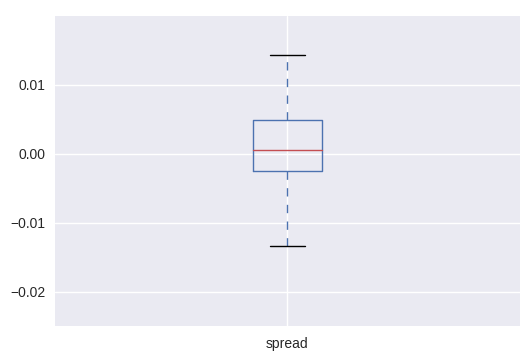

In [24]:
df_arima.boxplot(column='spread')
#df.boxplot(by='UD')
#plt.ylim(245,248)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac56b6fb70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fac55f22e48>]], dtype=object)

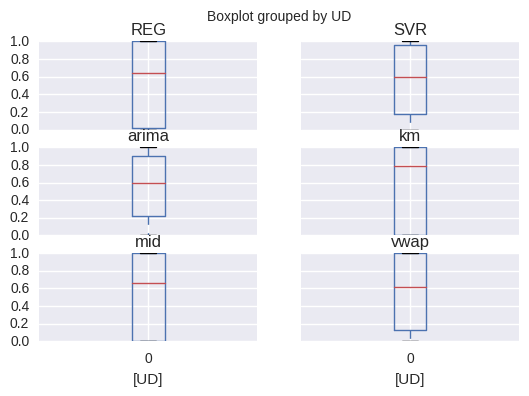

In [25]:
df_lstm.boxplot(by='UD')

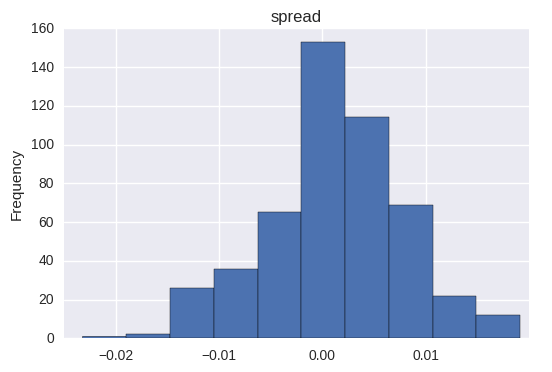

In [26]:
df_arima['spread'].plot(kind='hist', grid=True, title='spread')

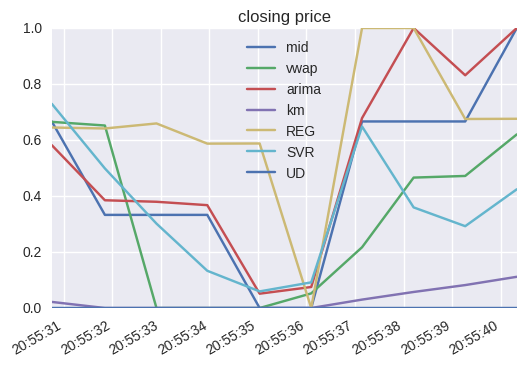

In [30]:
df_lstm.tail(10).plot(kind='line', grid=True, title='closing price')

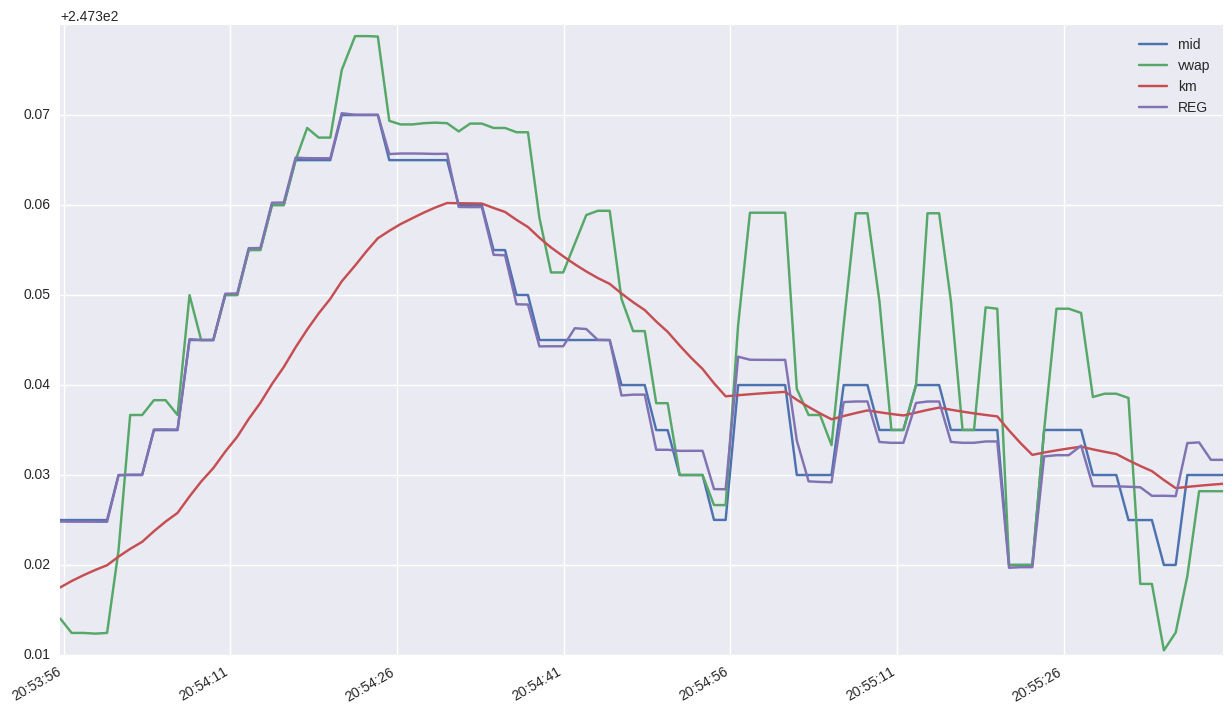

In [35]:
output[['mid','vwap','km','REG']].tail(100).plot(figsize=(15,9))
#df[['Volume']].tail(5000).plot(figsize=(15,9))
#data[['AvgVolume']].tail(5000).plot(figsize=(15,9))
plt.show()

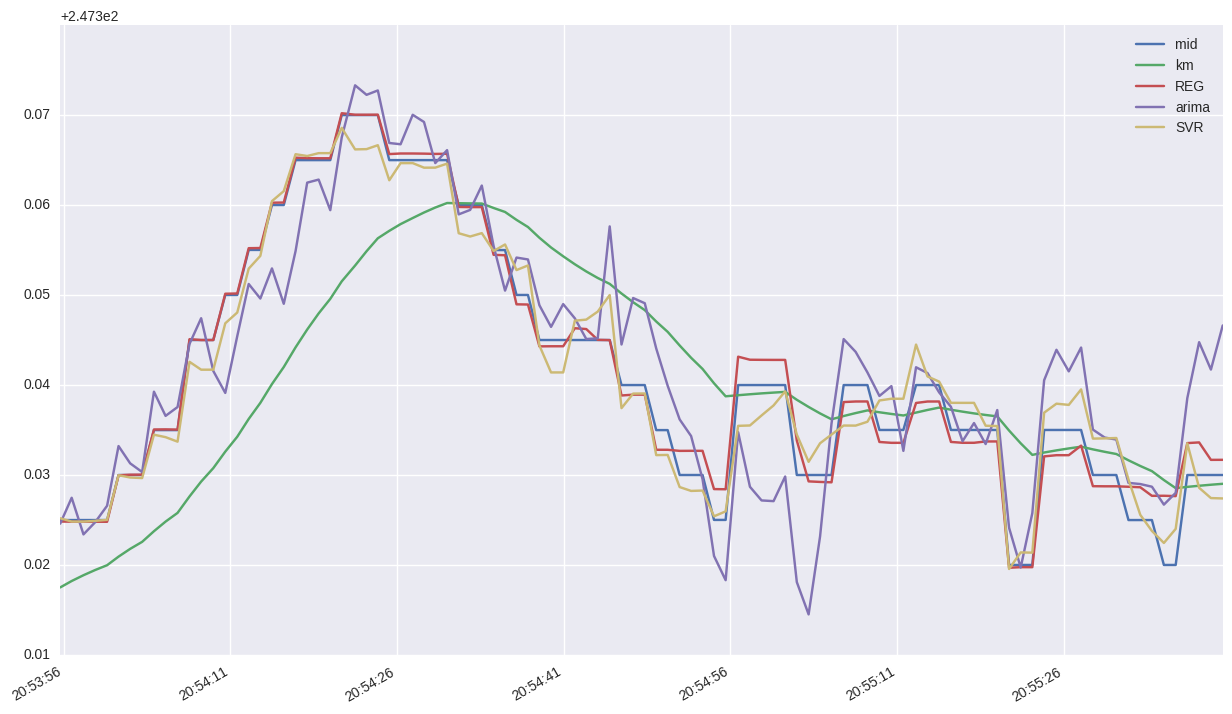

In [36]:
output[['mid','km','REG','arima','SVR']].tail(100).plot(figsize=(15,9))
#df[['Volume']].tail(5000).plot(figsize=(15,9))
#data[['AvgVolume']].tail(5000).plot(figsize=(15,9))
plt.show()